# Projeto_2

## Import of python libraries

In this section there are all the libraries used in the entire file listed so that it may be easy to read

In [15]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from math import sqrt
from geopy.geocoders import Nominatim
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

## Functions used along the code

All the function used along the code are listed here

In [2]:
def get_city_population(city):
    url = 'https://en.wikipedia.org/wiki/List_of_largest_cities_and_towns_in_Turkey'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', class_='wikitable')
    rows = table.find_all('tr')[1:]  # Exclude the header row
    for row in rows:
        columns = row.find_all('td')
        if columns[1].text.strip() == city:
            population = columns[6].text.strip()
            return population
    return 'Population not found'

def latitude(city):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(city)
    if location is not None:
        latitude = location.latitude
        return latitude
    else:
        return "Latitude not found"
    
def longitude(city):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(city)
    if location is not None:
        longitude = location.longitude
        return longitude
    else:
        return "Longitude not found"
    
def season(date):
    month = date.strftime('%B')
    day = date.day
    if month in ('January', 'February', 'March'):
        season = 'winter'
    elif month in ('April', 'May', 'June'):
        season = 'spring'
    elif month in ('July', 'August', 'September'):
        season = 'summer'
    else:
        season = 'autumn'
    if (month == 'March') and (day > 20):
        season = 'spring'
    elif (month == 'June') and (day > 20):
        season = 'summer'
    elif (month == 'September') and (day > 22):
        season = 'autumn'
    elif (month == 'December') and (day > 21):
        season = 'winter'
    return season

def holidays(date):
    year = date.strftime('%Y')
    formated = date.strftime('%#d %B')
    url = 'https://en.wikipedia.org/wiki/Public_holidays_in_Turkey'
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the table containing the holiday data
    table = soup.find_all('table', 'wikitable')[0]
    rows = table.find_all('tr')[1:]
    for row in rows:
        # Extract the cells of each row
        columns = row.find_all('td')
        if columns[0].text.strip() == formated:
            name = columns[1].text.strip()
            return name
    return 'Not Holiday'

## Data cleaning

In this section some data cleaning will be performed. The city names were corrected, null values were replaced using the interpolate function of pandas, aswell as a k-nearest neighbors algorithm, for the first 2 csv files.  
For the third csv file, some columns were droped, and null values were filed, around 7000 null values remain which means that ir represents less than 1 % of the entire csv file, so we made the decision to drop those lines.

In [3]:
cities_df = pd.read_csv("cities.csv")
cities_df['city_code'] = cities_df['city_code'].str.replace('?', 'i')
cities_df['city_code'] = cities_df['city_code'].str.replace('Sanliurfa', 'Şanlıurfa')
cities_df['city_code'] = cities_df['city_code'].str.replace('Izmir', 'İzmir')
cities_df['city_code'] = cities_df['city_code'].str.replace('Diyarbakir', 'Diyarbakır')
cities_df['city_code'] = cities_df['city_code'].str.replace('Eskiiehir', 'Eskişehir')
cities_df['city_code'] = cities_df['city_code'].str.replace('Adapazari', 'Adapazarı')
cities_df['city_code'] = cities_df['city_code'].str.replace('Kahramanmaras', 'Kahramanmaraş')
cities_df['city_code'] = cities_df['city_code'].str.title()

In [4]:
product_df = pd.read_csv("product.csv")

# Check for nulls and replace missing values
print(product_df.isna().sum())
product_df["product_length"].interpolate(method ='linear', limit_direction ='both', inplace=True)
product_df["product_depth"].interpolate(method ='linear', limit_direction ='both', inplace=True)
product_df["product_width"].interpolate(method ='linear', limit_direction ='both', inplace=True)
print(product_df.isna().sum())

# Split the data into complete and missing
complete_data = product_df.dropna()
missing_data = product_df[product_df['cluster_id'].isnull()].drop('cluster_id', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    complete_data[['product_length', 'product_depth', 'product_width']],
    complete_data['cluster_id'],
    test_size=0.2,
    random_state=42
)

# Perform K-nearest neighbors classification with hyperparameter tuning
parameters = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameters and model
best_k = grid_search.best_params_['n_neighbors']
best_weights = grid_search.best_params_['weights']
best_algorithm = grid_search.best_params_['algorithm']
best_leaf_size = grid_search.best_params_['leaf_size']
best_p = grid_search.best_params_['p']
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Predict clusters for missing data using the best model
missing_data['cluster_id'] = best_model.predict(missing_data[['product_length', 'product_depth', 'product_width']])

# Concatenate the complete data with the imputed missing data
result_df = pd.concat([complete_data, missing_data])

# Print the resulting DataFrame with clusters
print(result_df)
print(result_df.isna().sum())

result_df.to_csv("product_df.csv", index=False)

product_id         0
product_length    18
product_depth     16
product_width     16
cluster_id        50
hierarchy1_id      0
hierarchy2_id      0
hierarchy3_id      0
hierarchy4_id      0
hierarchy5_id      0
dtype: int64
product_id         0
product_length     0
product_depth      0
product_width      0
cluster_id        50
hierarchy1_id      0
hierarchy2_id      0
hierarchy3_id      0
hierarchy4_id      0
hierarchy5_id      0
dtype: int64
Accuracy: 0.6076923076923076
Precision: 0.07022222222222223
Recall: 0.10449735449735449
F1-score: 0.08399787347155768
    product_id  product_length  product_depth  product_width cluster_id  \
1        P0001            13.5           22.0           20.0  cluster_5   
2        P0002            22.0           40.0           22.0  cluster_0   
3        P0004             2.0           13.0            4.0  cluster_3   
4        P0005            16.0           30.0           16.0  cluster_9   
5        P0006             8.5           15.0           15.0 

In [5]:
sales_df = pd.read_csv("sales.csv")
sales_df = sales_df[sales_df["date"] < "2019-10-01"]
sales_df = sales_df.drop(sales_df.columns[0], axis=1)
print(sales_df.isna().sum())

#fill the price
sales_df['price'] = sales_df.groupby('product_id')['price'].transform(lambda x: x.fillna(x.mean()))
print(sales_df.isna().sum())
#after this some nulls still remain, that means that the dataset contains products for which there isnt a price in any place

#drop columns with a lot of nulls
sales_df.drop(['promo_bin_2', 'promo_discount_2', 'promo_discount_type_2'], axis=1, inplace=True)

#count distinct values of a column
value_counts = sales_df['promo_type_2'].value_counts()
print(value_counts)

# Given that less than one percent of the data related to promo_type_2 is different from the majority of the values
# we will drop this column aswell
sales_df.drop(['promo_type_2'], axis=1, inplace=True)

value_counts = sales_df['promo_type_1'].value_counts()
print(value_counts)

value_counts = sales_df['promo_bin_1'].value_counts()
print(value_counts)

sales_df['promo_bin_1'].fillna("none", inplace=True)

#binary_cols = pd.get_dummies(sales_df['promo_bin_1'], prefix='promo_bin_')
#sales_df = pd.concat([sales_df, binary_cols], axis=1)

#binary_cols = pd.get_dummies(sales_df['promo_type_1'], prefix='promo_type_')
#sales_df = pd.concat([sales_df, binary_cols], axis=1)

#sales_df.drop(['promo_type_1', 'promo_bin_1'], axis=1, inplace=True)

# Dropping the remaing null values of the price its around 7000 so less then 1% see after model if it affects a lot
sales_df.dropna(inplace=True)
print(sales_df.isna().sum())
sales_df.head()
sales_df.to_csv("sales_df.csv", index=False)

store_id                       0
product_id                     0
date                           0
sales                          0
revenue                        0
stock                          0
price                      89409
promo_type_1                   0
promo_bin_1              7401743
promo_type_2                   0
promo_bin_2              8575279
promo_discount_2         8575279
promo_discount_type_2    8575279
dtype: int64
store_id                       0
product_id                     0
date                           0
sales                          0
revenue                        0
stock                          0
price                       6670
promo_type_1                   0
promo_bin_1              7401743
promo_type_2                   0
promo_bin_2              8575279
promo_discount_2         8575279
promo_discount_type_2    8575279
dtype: int64
PR03    8575279
PR02       6120
PR01       2275
PR04         88
Name: promo_type_2, dtype: int64
PR14    7401743
PR0

# Adding external variables 

In [6]:
# Add a new column to store population
cities_df['Population'] = cities_df['city_code'].apply(get_city_population)
cities_df['Latitude'] = cities_df['city_code'].apply(latitude)
cities_df['Longitude'] = cities_df['city_code'].apply(longitude)

print(cities_df)

#It doesnt work for Izmir so replace manually
cities_df['Population'] = cities_df['Population'].str.replace('Population not found', '2,847,691')

# remove the commas
cities_df['Population'] = cities_df['Population'].str.replace(',', '')

cities_df.to_csv("cities_df.csv", index=False)

   store_id storetype_id  store_size city_id_old country_id      city_code  \
0     S0036         ST04          21        C001     TURKEY        Denizli   
1     S0005         ST04          19        C001     TURKEY        Denizli   
2     S0104         ST04          47        C002     TURKEY         Ankara   
3     S0068         ST03          14        C003     TURKEY          Izmir   
4     S0086         ST03          12        C003     TURKEY          Izmir   
..      ...          ...         ...         ...        ...            ...   
58    S0040         ST04          42        C017     TURKEY  Kahramanmaraş   
59    S0046         ST04          26        C017     TURKEY  Kahramanmaraş   
60    S0102         ST04          27        C018     TURKEY        Erzurum   
61    S0032         ST03          14        C019     TURKEY            Van   
62    S0061         ST04          35        C019     TURKEY            Van   

              Population   Latitude  Longitude  
0             

In [ ]:
df_1 = pd.read_csv("sales_df.csv")
df_1 = df_1[['date']].copy()
df_1.drop_duplicates(inplace=True)
df_1['date'] = pd.to_datetime(df_1['date'])
print(df_1)
df_1['season'] = df_1['date'].apply(season)
print(df_1)

In [ ]:
df_1['holidays'] = df_1['date'].apply(holidays)
print(df_1)

#change some values manually
df_1.to_csv("season_holidays.csv", index=False)

# Graphs

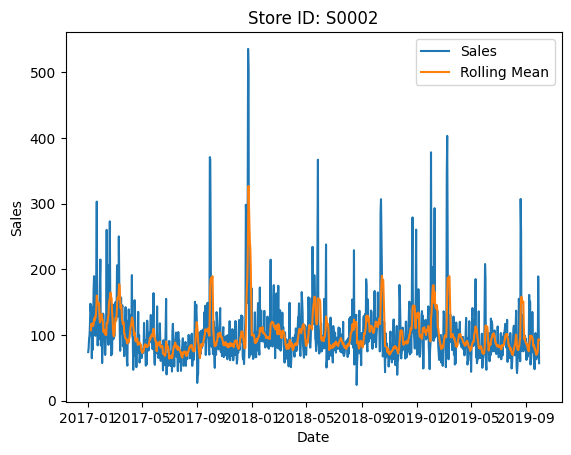

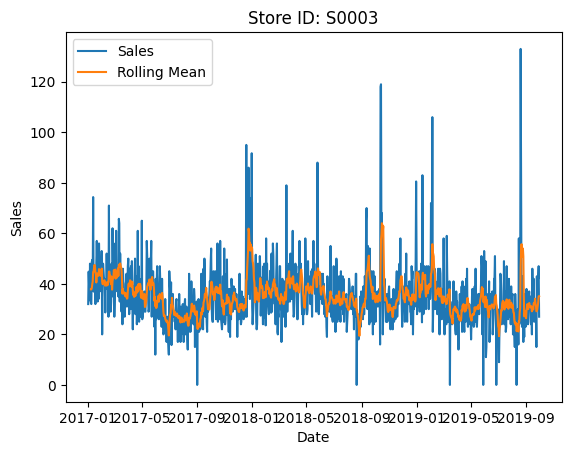

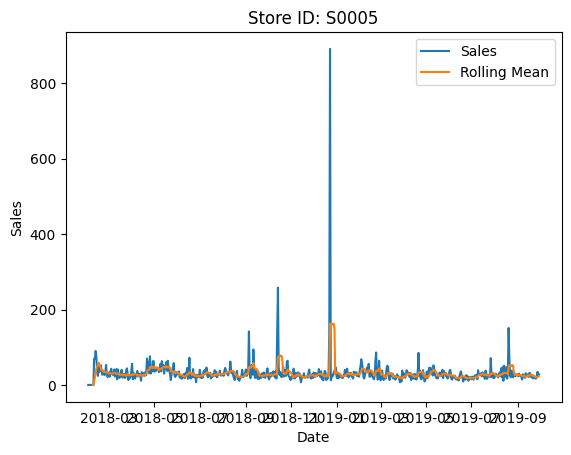

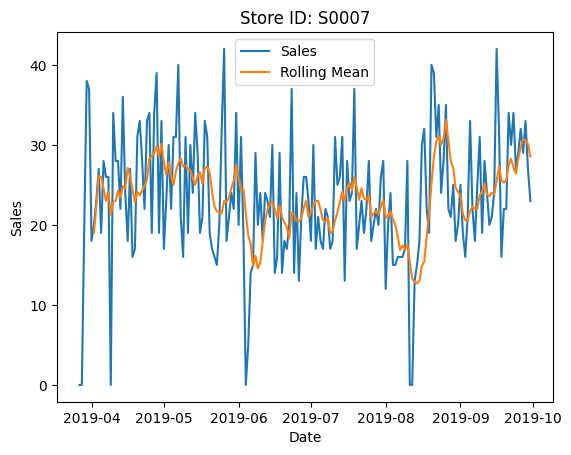

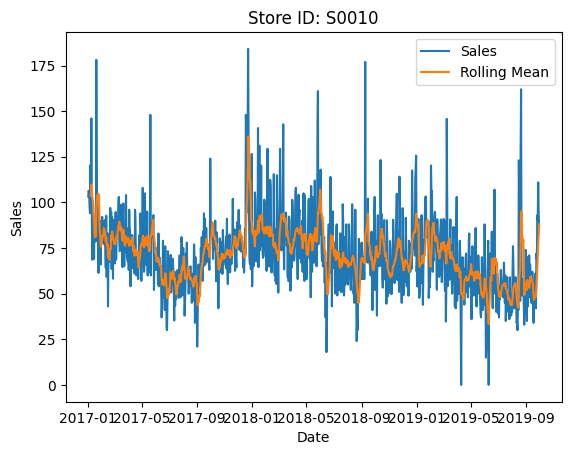

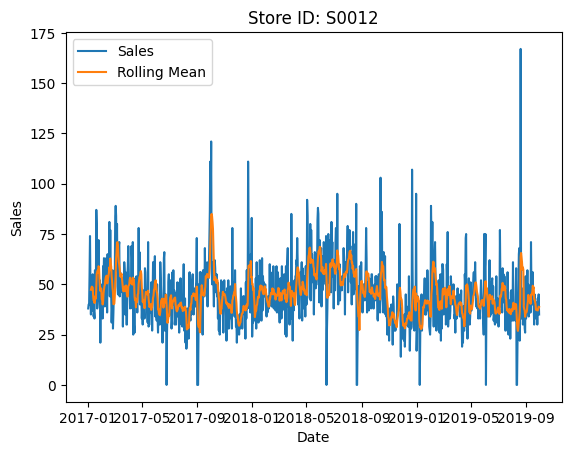

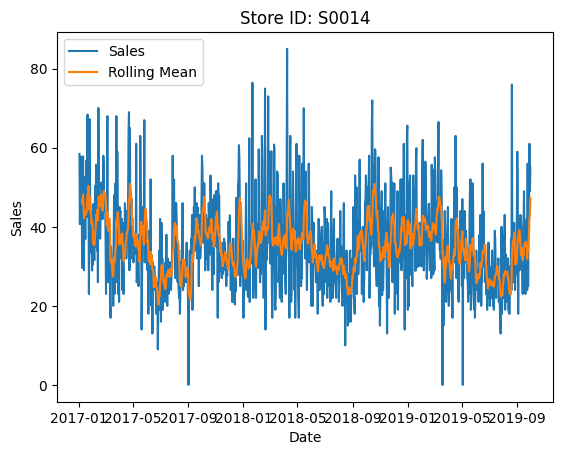

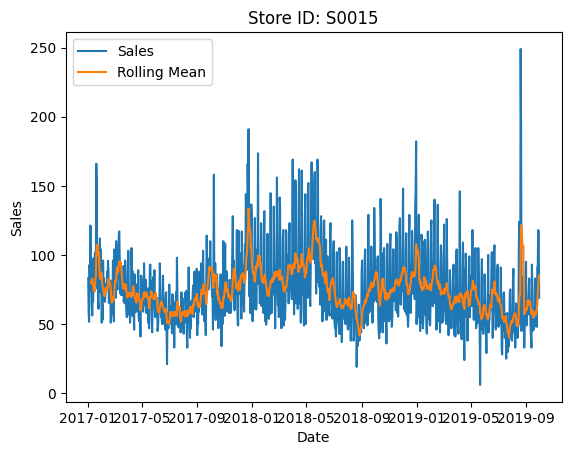

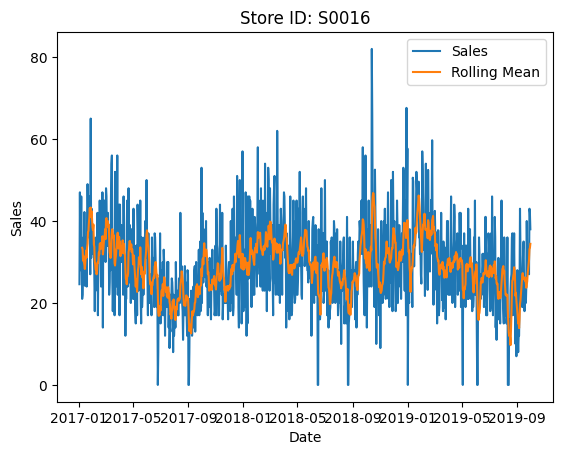

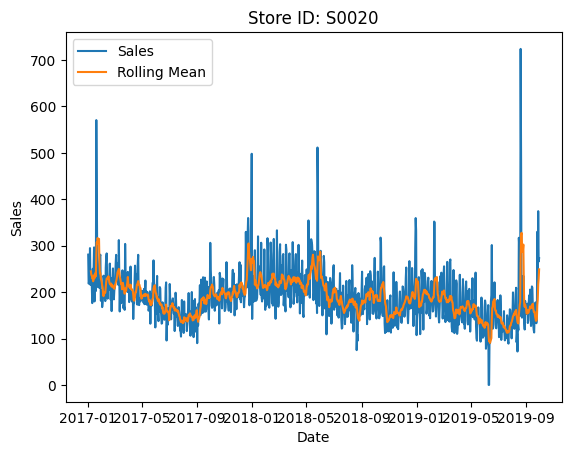

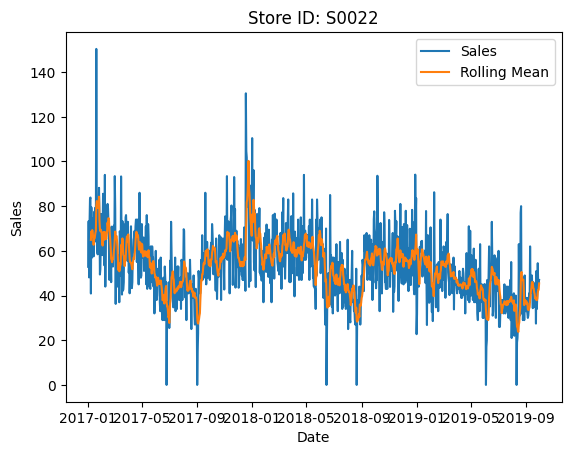

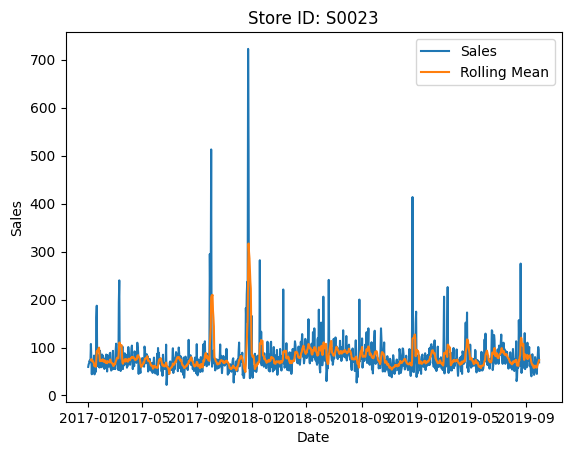

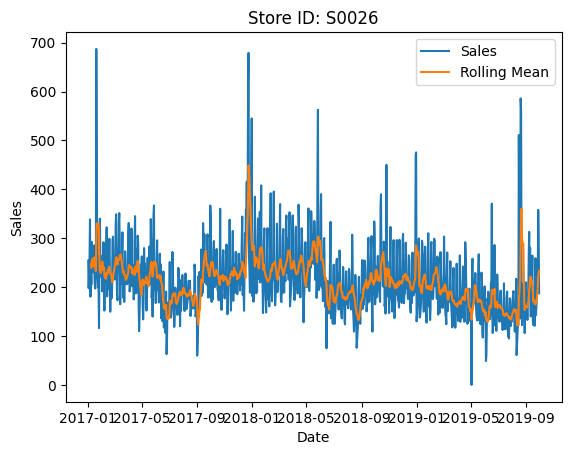

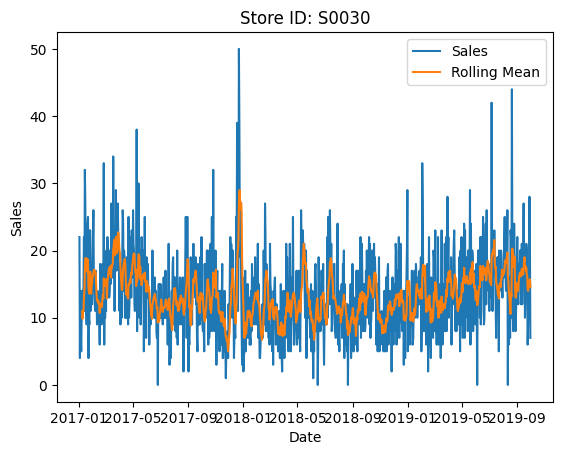

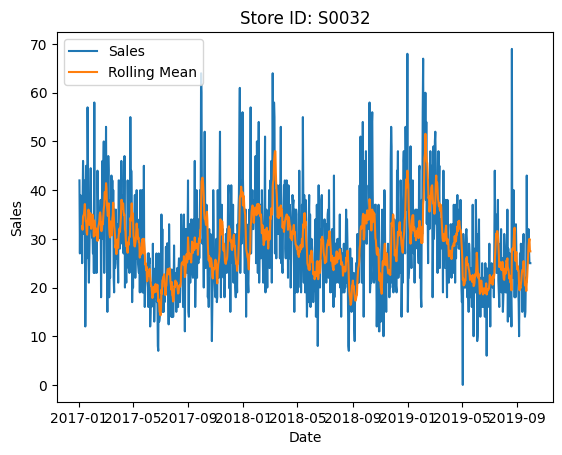

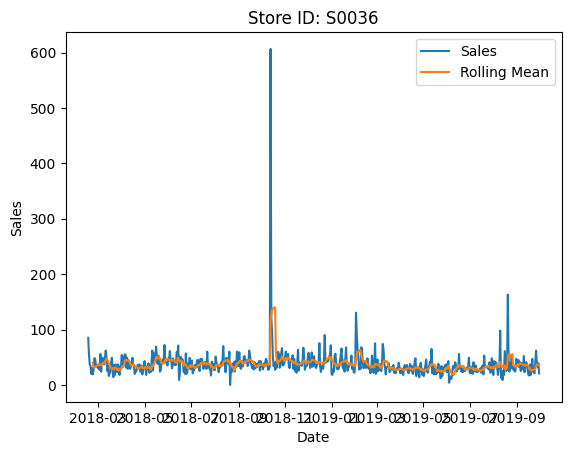

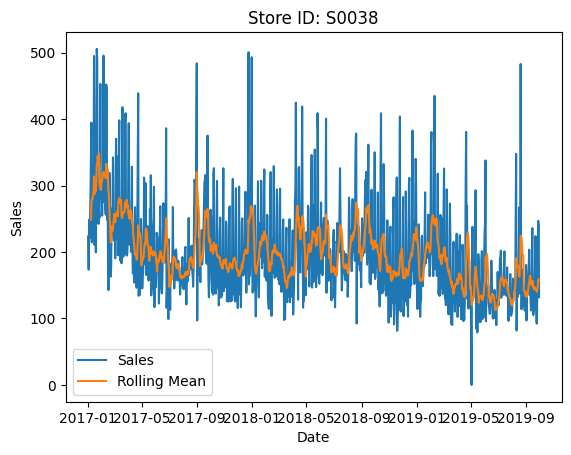

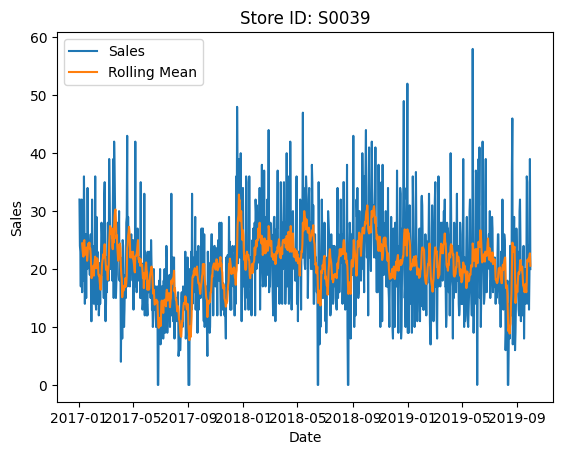

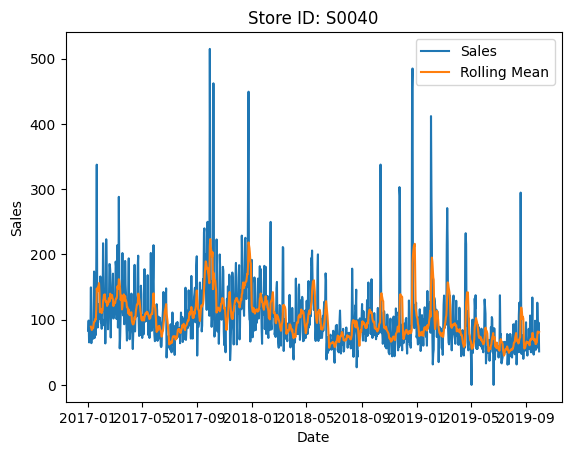

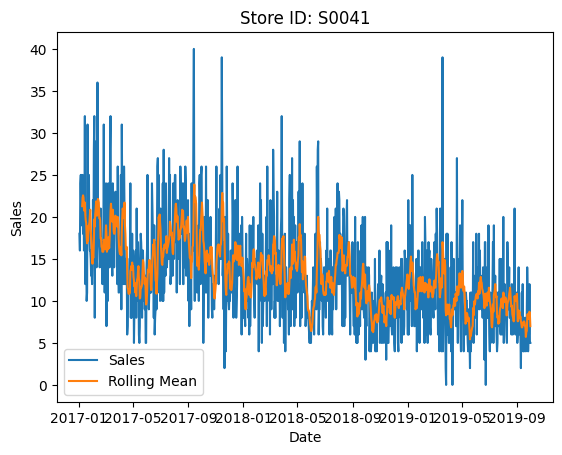

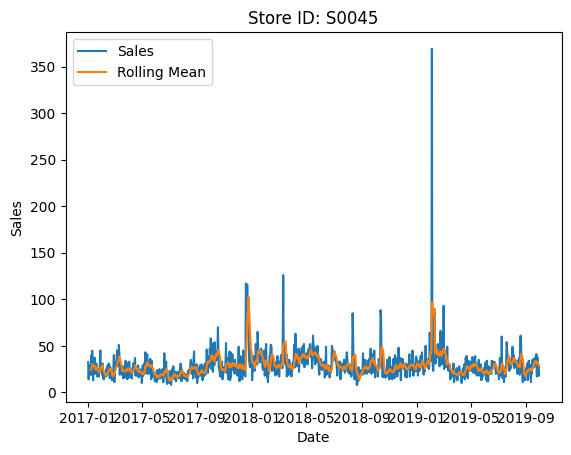

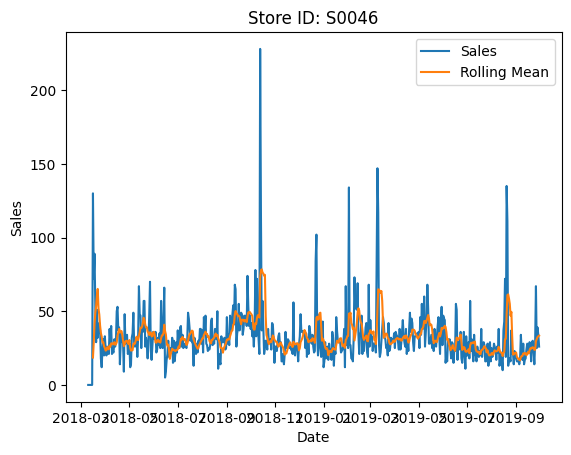

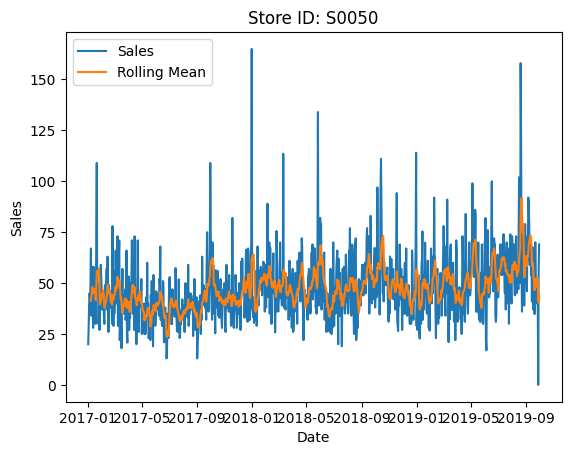

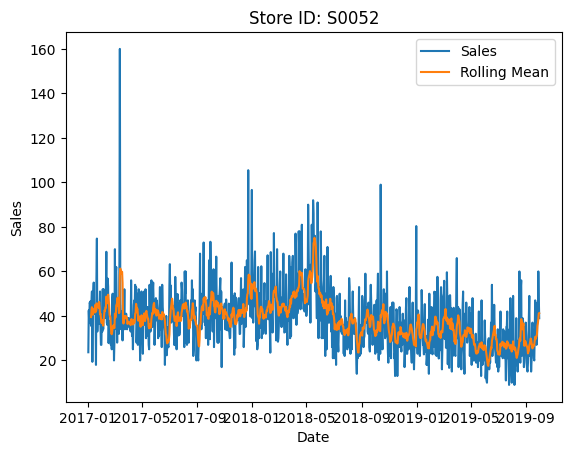

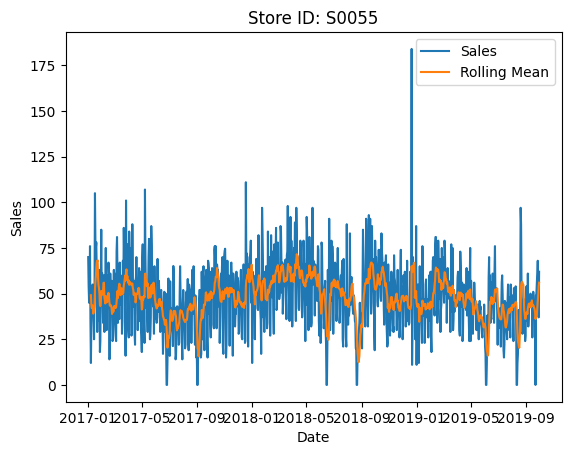

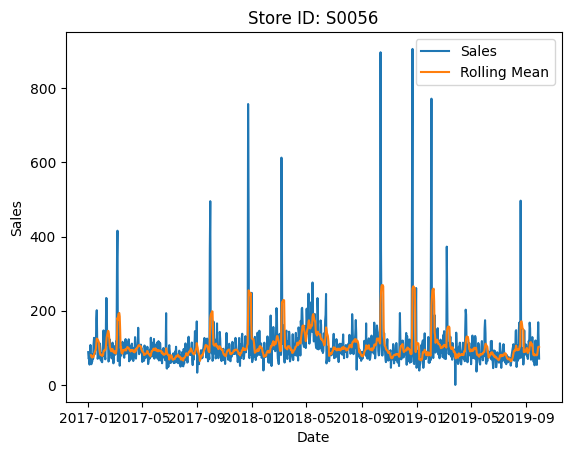

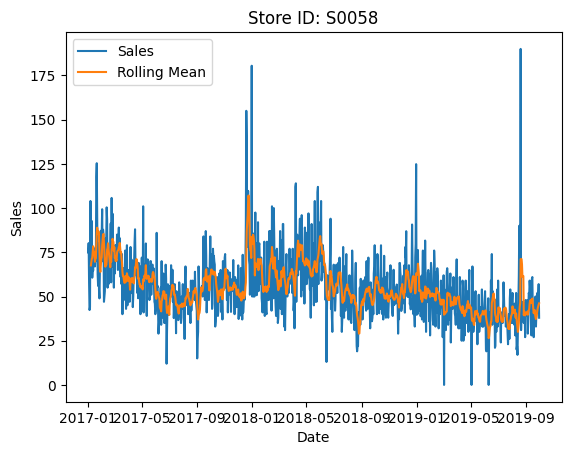

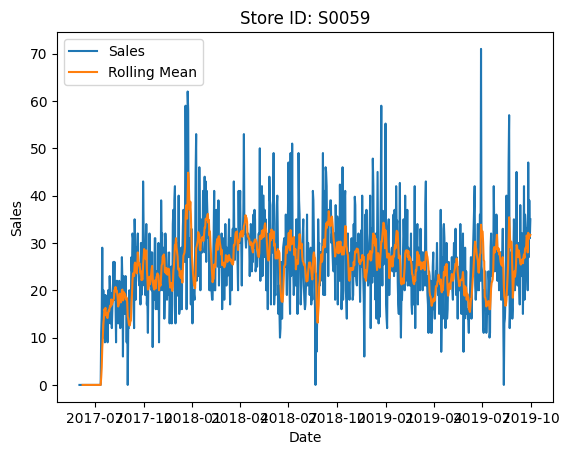

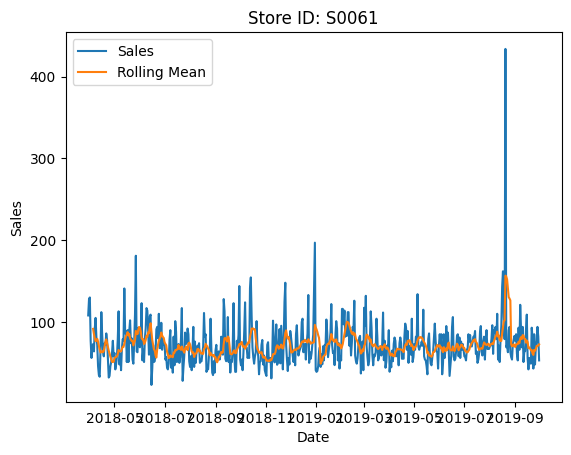

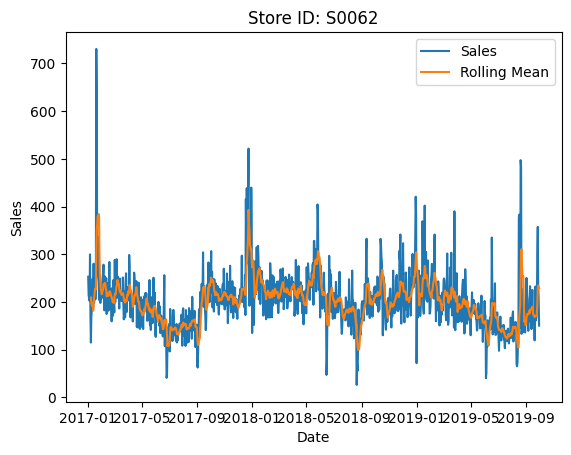

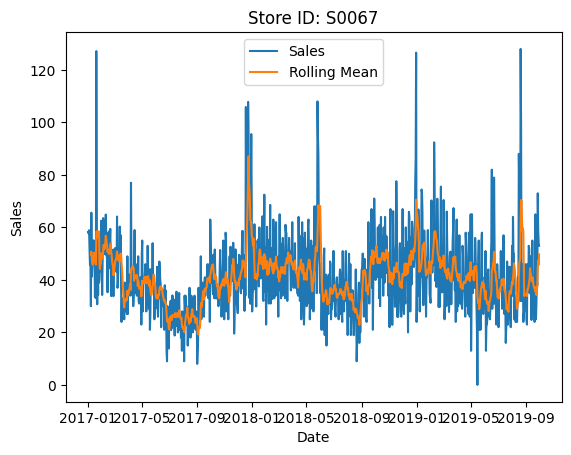

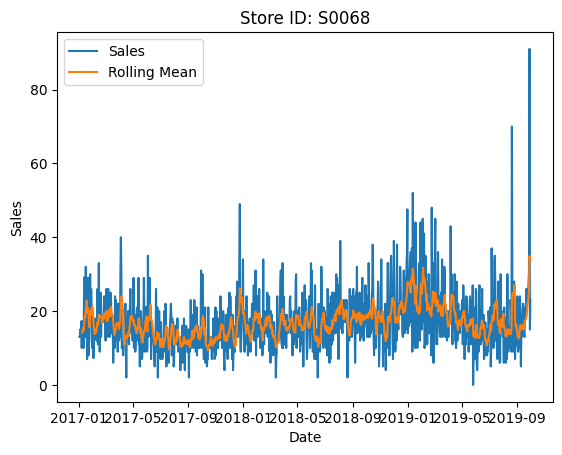

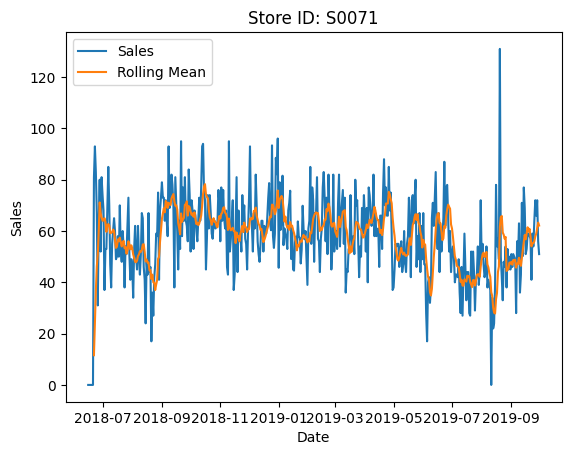

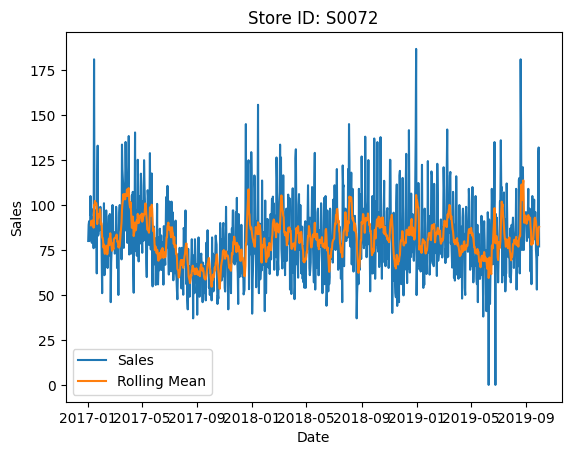

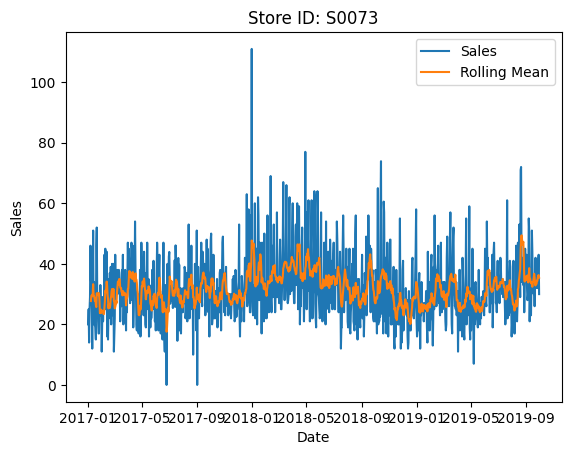

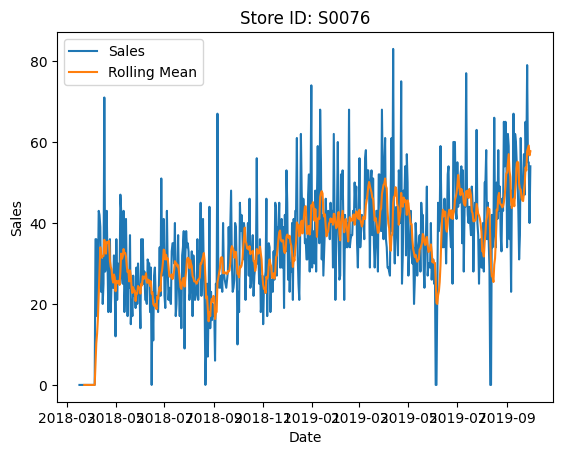

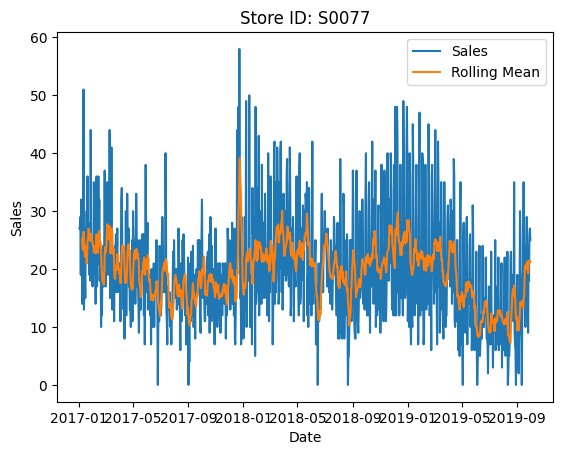

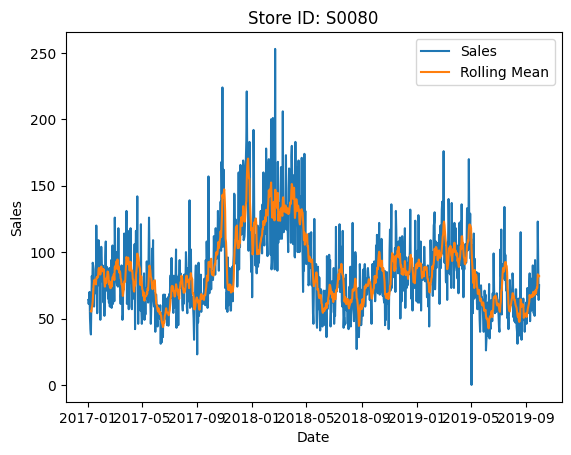

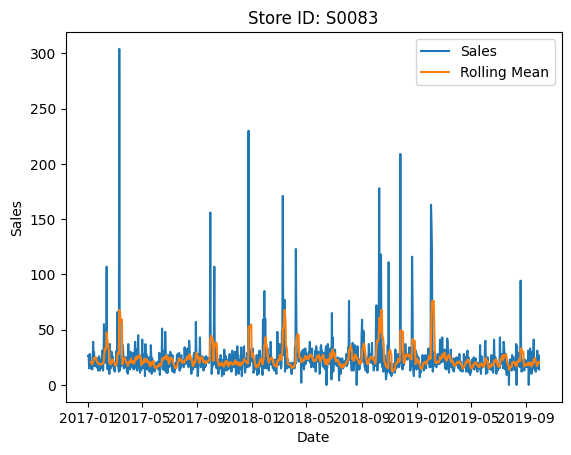

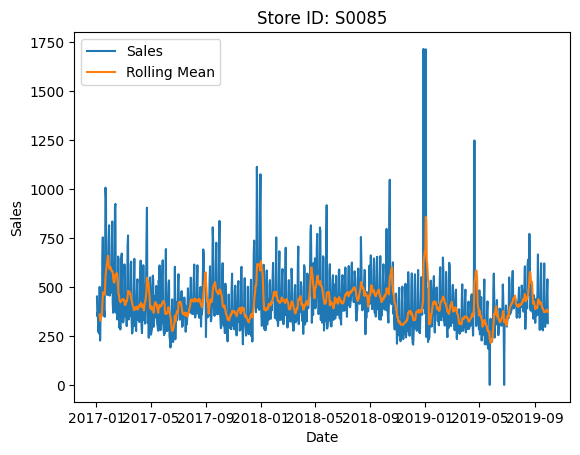

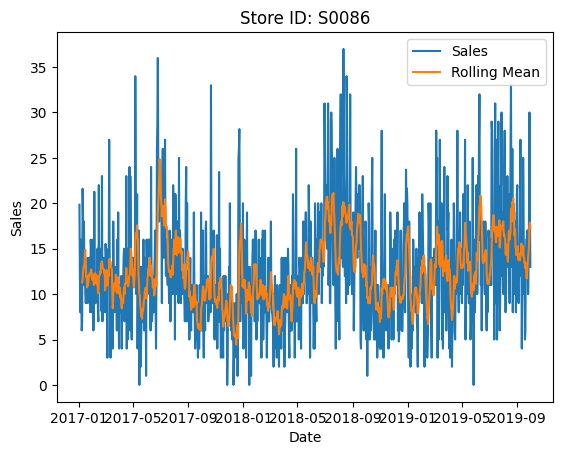

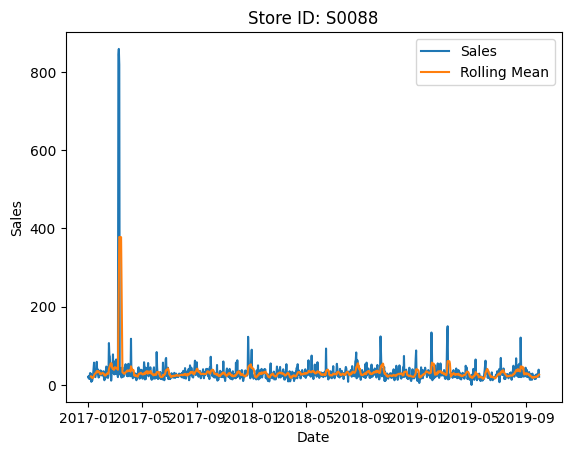

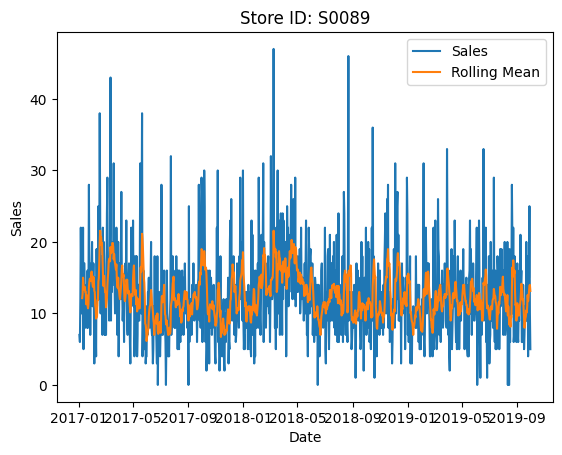

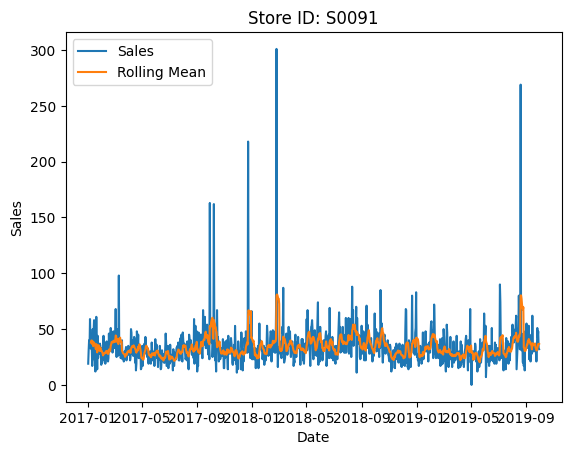

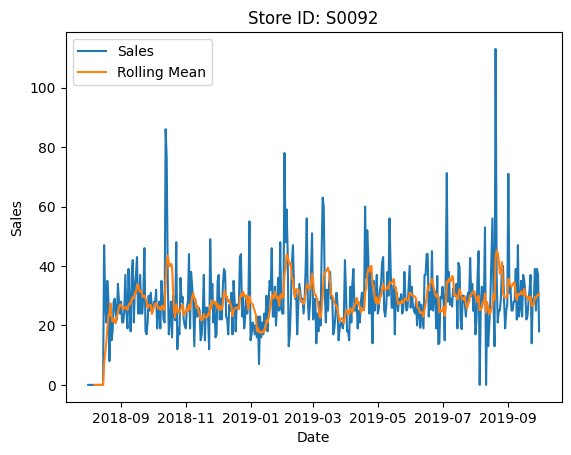

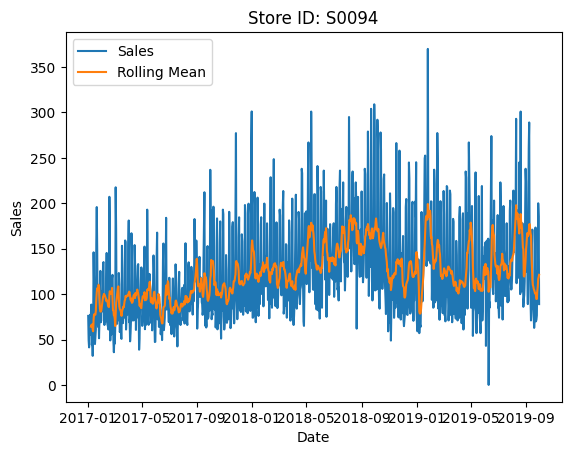

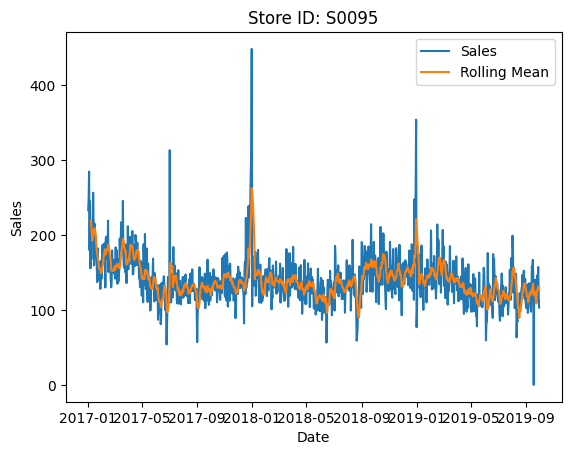

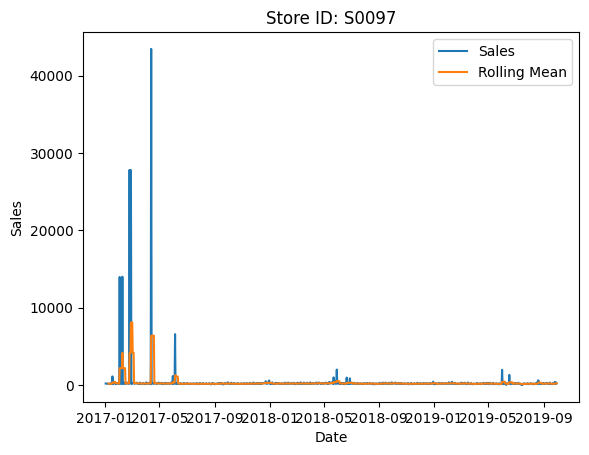

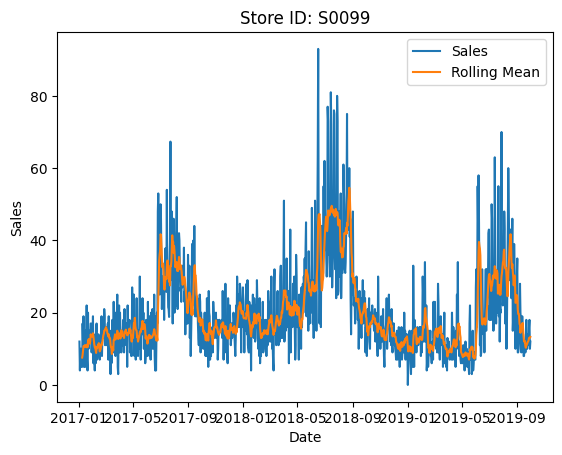

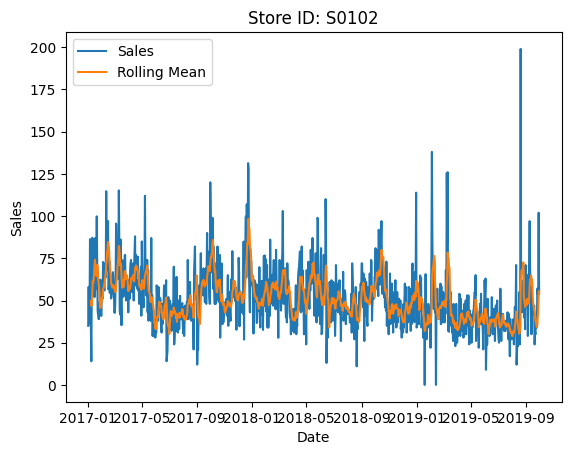

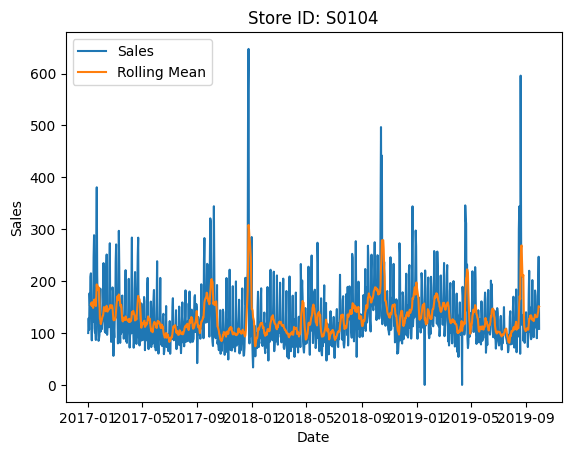

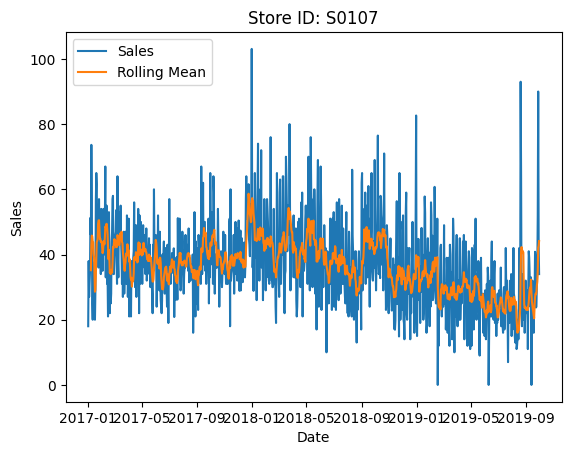

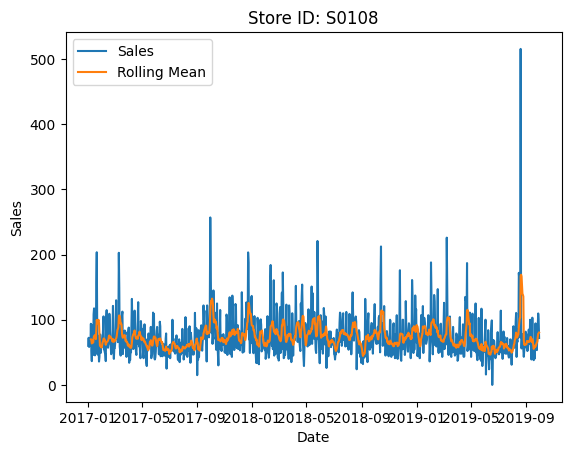

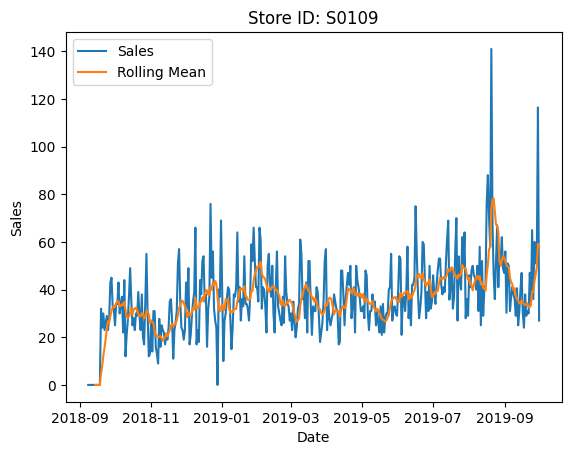

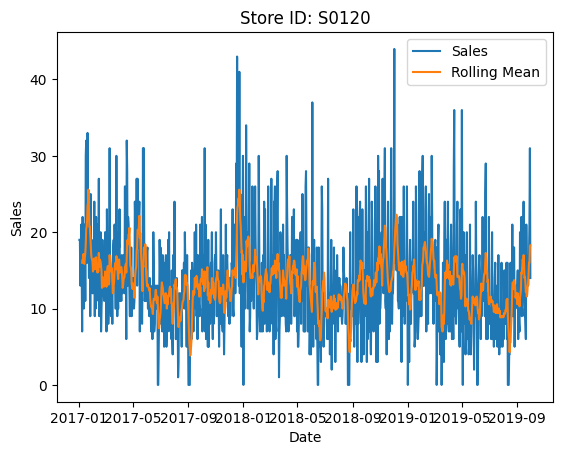

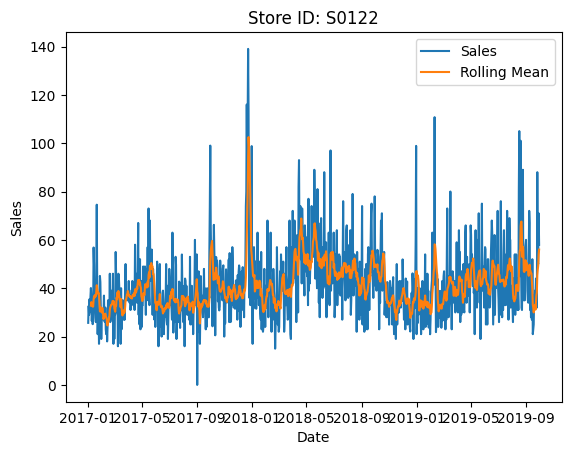

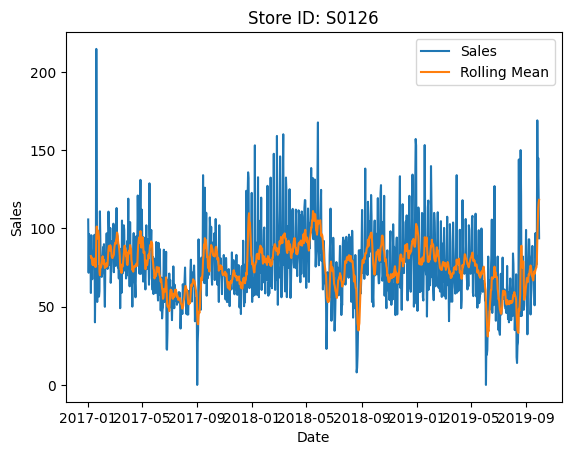

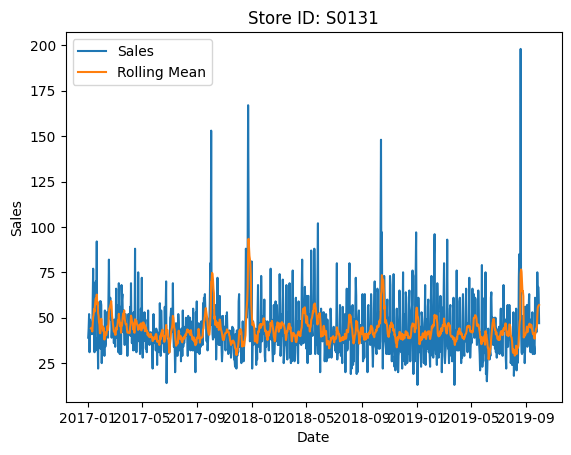

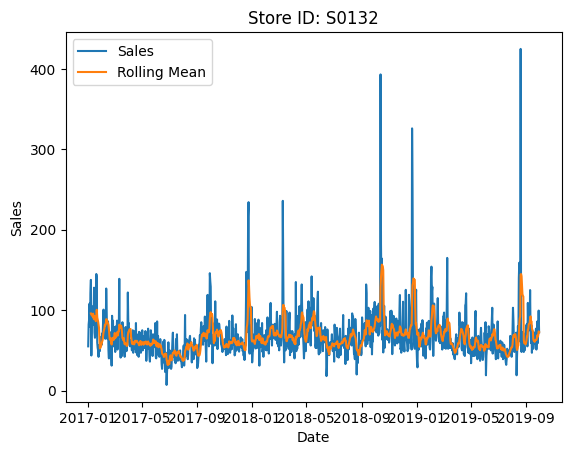

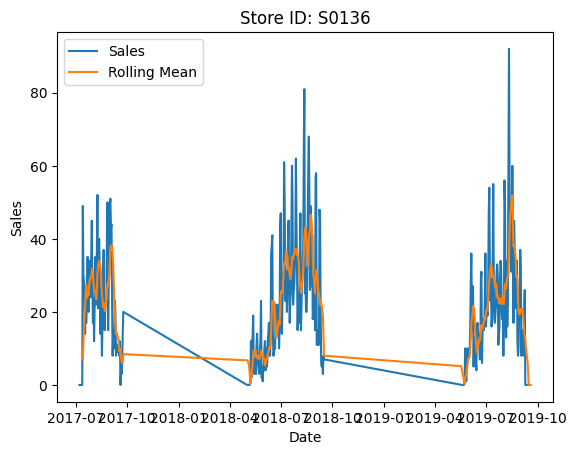

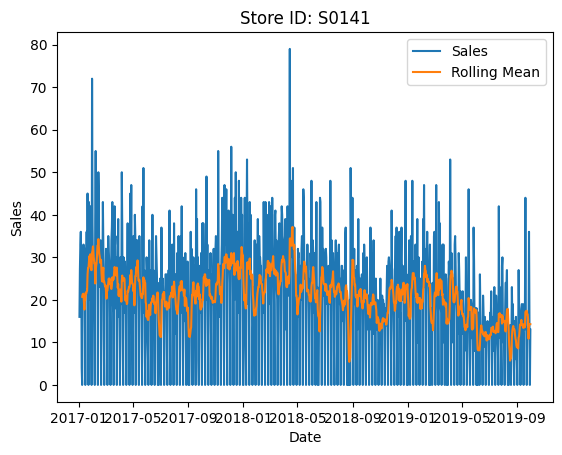

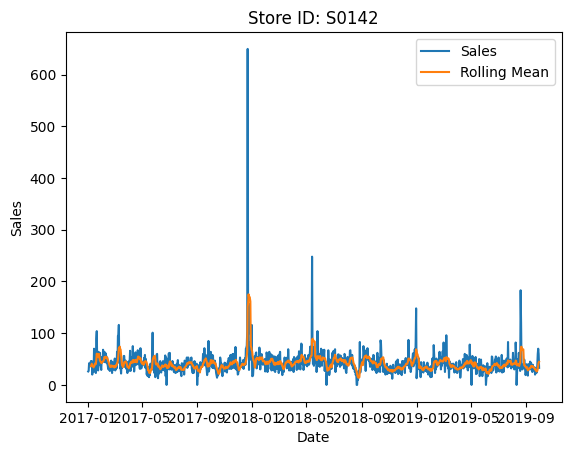

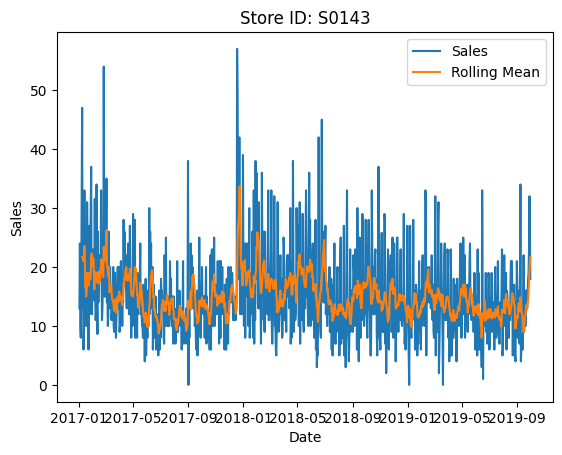

In [ ]:
df = pd.read_csv('sales_df.csv')
df['date'] = pd.to_datetime(df['date'])
aggregated_df = df.groupby(['date', 'store_id']).agg({'sales': 'sum'}).reset_index()

grouped_df = aggregated_df.groupby('store_id')
for store_id, group_data in grouped_df:
    # Perform time series analysis on the group_data DataFrame
    # You can use methods like rolling mean, exponential smoothing, etc.
    # Example:
    rolling_mean = group_data['sales'].rolling(window=7).mean()
    
    # Plot the time series
    plt.figure()
    plt.plot(group_data['date'], group_data['sales'], label='Sales')
    plt.plot(group_data['date'], rolling_mean, label='Rolling Mean')
    plt.title(f"Store ID: {store_id}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

## Transforming data for future analysis

In [ ]:
"""
unique_combinations = sales_df[['store_id', 'date']].drop_duplicates()
merged_df = unique_combinations.merge(cities_df, on='store_id', how='left')
print(merged_df)
unique_combinations_2 = merged_df[['city_code', 'date']].drop_duplicates()
print(unique_combinations_2)
print(len(unique_combinations_2))
"""

In [ ]:
"""
sales_df['date'] = pd.to_datetime(sales_df['date'])  # Convert 'date' column to datetime type

future_ts = sales_df.groupby([pd.Grouper(key='date', freq='W-MON'), 'store_id']) \
    .agg(total_sales=('sales', 'sum'),
         total_revenue=('revenue', 'sum'),
         total_stock=('stock', 'sum'),
         average_price=('price', 'mean'),
         promo_type_count=('promo_type_1', 'nunique'),
         promo_bin_count=('promo_bin_1', 'nunique')) \
    .round()

print(future_ts)
future_ts.head
"""

# TESTING AREA

## RANDOM FOREST

In [ ]:
# Carregar os dados
sales_df = pd.read_csv("sales_df.csv")
sales_df['date'] = pd.to_datetime(sales_df['date'])
one_store = sales_df.query("store_id == 'S0002'")
one_store.drop(['store_id'], axis=1, inplace=True)
future_ts = one_store.groupby([pd.Grouper(key='date', freq='W-MON')]) \
    .agg(total_sales=('sales', 'sum'),
         total_revenue=('revenue', 'sum'),
         average_price=('price', 'mean'),
         promo_type_count=('promo_type_1', 'nunique'),
         promo_bin_count=('promo_bin_1', 'nunique')) \
    .round()

train_data = future_ts[:-2]  
test_data = future_ts[-2:] 

X_train = train_data[['total_revenue', 'average_price', 'promo_type_count','promo_bin_count']]  
y_train = train_data['total_sales'] 

X_test = train_data[['total_revenue', 'average_price', 'promo_type_count','promo_bin_count']]  
y_test = train_data['total_sales']  


#Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliação do modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

# Tunning do modelo

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Criar o modelo de ensemble (Random Forest)
model_bp = RandomForestRegressor(random_state=42)

# Realizar busca em grade para encontrar os melhores parâmetros
grid_search = GridSearchCV(estimator=model_bp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Melhores parâmetros encontrados
best_params = grid_search.best_params_
print('Melhores parâmetros:', best_params)

# Avaliação do modelo com os melhores parâmetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f'RMSE: {rmse}')

In [ ]:
sales_df = pd.read_csv("sales_df.csv")
sales_df['date'] = pd.to_datetime(sales_df['date'])
one_store = sales_df.query("store_id == 'S0002'")
one_store.drop(['store_id'], axis=1, inplace=True)
future_ts = one_store.groupby([pd.Grouper(key='date', freq='W-MON')]) \
    .agg(total_sales=('sales', 'sum'),
         total_revenue=('revenue', 'sum'),
         average_price=('price', 'mean'),
         promo_type_count=('promo_type_1', 'nunique'),
         promo_bin_count=('promo_bin_1', 'nunique')) \
    .round()

print(future_ts)


## ARIMA

In [ ]:
sales_df = pd.read_csv("sales_df.csv")
holidays_df = pd.read_csv("season_holidays.csv")

holidays_df.loc[holidays_df['holidays'] != 'Not Holiday', 'holidays'] = 'Holiday'
holidays_df['holidays'] = holidays_df['holidays'].apply(lambda x: 1 if x == 'Holiday' else 0)
holidays_df = pd.get_dummies(holidays_df, columns=['season'])

one_store = sales_df.query("store_id == 'S0002'")

one_store = one_store.groupby([pd.Grouper(key='date')]) \
    .agg(total_sales=('sales', 'sum'),
         total_revenue=('revenue', 'sum'),
         average_price=('price', 'mean'))\
    .round()

merged_df = one_store.merge(holidays_df, on='date', how='left')

merged_df['date'] = pd.to_datetime(merged_df['date'])

print(merged_df)

### ARIMA WEEKLY

In [ ]:
# explorar dataframe
merged_df.head()
merged_df.info()
merged_df.plot()

# decomposicao ETS (Error, Trend, Seasonality)
result = seasonal_decompose(merged_df['total_sales'], model ='multiplicative')

merged_df = merged_df.reset_index()
# Split the data into training and test sets
train_data = merged_df[:-2]  # Use all data except the last two weeks for training
test_data = merged_df[-2:]  # Last two weeks for testing

# Fit the auto_arima model to the training data
model = auto_arima(train_data['total_sales'], seasonal=True, m=52)

# Generate predictions for the test data (last two weeks)
predictions = model.predict(n_periods=len(test_data))

# Combine the test data with the predictions
test_data['predictions'] = predictions

# Calculate evaluation metrics
mae = mean_absolute_error(test_data['total_sales'], test_data['predictions'])
mse = mean_squared_error(test_data['total_sales'], test_data['predictions'])
rmse = mean_squared_error(test_data['total_sales'], test_data['predictions'], squared=False)

# Print the test data, predictions, and evaluation metrics
print(test_data[['date', 'total_sales', 'predictions']])
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

### ARIMA DAILY

In [ ]:
"""
Careful to run it hasnt been tuned, it takes a long time for now
"""

# explorar dataframe
merged_df.head()
merged_df.info()
merged_df.plot()

# Split the data into training and test sets
train_data = merged_df[:-7]  # Use all data except the last two weeks for training
test_data = merged_df[-7:]  # Last two weeks for testing

# Fit the auto_arima model to the training data
model = auto_arima(train_data['total_sales'], seasonal=True, m=365)

# Generate predictions for the test data (last two weeks)
predictions = model.predict(n_periods=len(test_data))

# Combine the test data with the predictions
test_data['predictions'] = predictions

# Calculate evaluation metrics
mae = mean_absolute_error(test_data['total_sales'], test_data['predictions'])
mse = mean_squared_error(test_data['total_sales'], test_data['predictions'])
rmse = mean_squared_error(test_data['total_sales'], test_data['predictions'], squared=False)

# Print the test data, predictions, and evaluation metrics
print(test_data[['date', 'total_sales', 'predictions']])
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

print(test_data.sum())